# Lane-Emden polytrope equation

We want to solve the Lane-Emden equation:
\begin{equation}
\frac{1}{\xi^2} \frac{d}{d\xi} \left (\xi^2 \frac{d\theta}{d\xi} \right ) = -\theta^n
\end{equation}
using a Runge-Kutta integration.  We will rewrite this as 2 first order equations:
\begin{eqnarray*}
\frac{dy}{d\xi} &=& z \\
\frac{dz}{d\xi} &=& -\frac{2}{\xi}z - y^n
\end{eqnarray*}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

This is our main class that does the integration.  We initialize it with the polytopic index, and then it will integrate the system for us.  We can then plot it or get
the parameters $\xi_1$ and $-\xi_1^2 d\theta/d\xi |_{\xi_1}$

We estimate the radius, $\xi_1$ each step and make sure that the next step does not take us past that estimate.  This prevents us from having negative $\theta$ values.  Given a point $(\xi_0, y_0)$, and the derivative at that point, $z_0 = dy/d\xi |_{\xi_0}$, we can write the equation of a line as:
\begin{equation}
    y(\xi) - y_0 = z_0 (\xi - \xi_0)
\end{equation}
Then we can ask when does $y$ become zero, finding:
\begin{equation}
    \xi = -\frac{y_0}{z_0} + \xi_0
\end{equation}
This is our estimate of $\xi_1$.  We then make sure our stepsize $h$ is small enough that we do not go beyond this estimate.

This class uses 4th-order Runge-Kutta (or first-order Euler if we call with `first_order=True`) with a fixed stepsize, `h0`, until we reach the edge of the star.  We need to be careful to choose a value of `h0` small enough to get an accurate solution.  Ideally, we should implement a method that automatically does error estimation as it integrates, and varies the stepsize as needed.

In [2]:
class Polytrope:
    """a polytrope of index n"""
    def __init__(self, n, first_order=False, h0=0.1, tol=1.e-12):
        self.n = n
        
        # storage for the solution history
        self.xi = []
        self.theta = []
        self.dtheta_dxi = []
        
        # solution for the current solution point (y, z) -- initialized to
        # the boundary conditions
        self.q = np.array([1.0, 0.0], dtype=np.float64)
        
        # already integrate the solution
        if first_order:
            self._integrate_euler(h0, tol)
        else:
            self._integrate_rk4(h0, tol)

        # convert the data to a numpy array so we can more easily
        # manipulate it
        self.xi = np.asarray(self.xi)
        self.theta = np.asarray(self.theta)
        self.dtheta_dxi = np.asarray(self.dtheta_dxi)

    def store_solution(self, xi, y, z):
        """store the current solution point in the history"""
        self.xi.append(xi)
        self.theta.append(y)
        self.dtheta_dxi.append(z)
        
    def _estimate_h(self, hin, xi):
        """estimate the new step size to ensure that theta does not
        go negative"""

        # Our systems is always convex (theta'' < 0), so the
        # intersection of theta' with the x-axis will always be
        # a conservative estimate of the radius of the star.
        # Make sure that the stepsize does not take us past that.        
        R_est = xi - self.q[0]/self.q[1]
        if xi + hin > R_est:
            return -self.q[0]/self.q[1]
        return hin
        
    def _integrate_euler(self, h0, tol):
        """integrate the Lane-Emden system using first-order Euler"""

        xi = 0.0
        h = h0

        while h > tol:
            self.q += h * self._rhs(xi, self.q)
            xi += h

            h = self._estimate_h(h, xi)

            # store the solution
            self.store_solution(xi, self.q[0], self.q[1])

    def _integrate_rk4(self, h0, tol):
        """integrate the Lane-Emden system"""

        xi = 0.0
        h = h0

        while h > tol:
            # 4th order RK integration -- first find the slopes
            k1 = self._rhs(xi, self.q)
            k2 = self._rhs(xi+0.5*h, self.q+0.5*h*k1)
            k3 = self._rhs(xi+0.5*h, self.q+0.5*h*k2)
            k4 = self._rhs(xi+h, self.q+h*k3)

            # now update the solution to the new xi
            self.q += (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            xi += h

            h = self._estimate_h(h, xi)
            
            # store the solution:
            self.store_solution(xi, self.q[0], self.q[1])

    def _rhs(self, xi, q):
        """ the righthand side of the LE system, q' = f"""

        f = np.zeros_like(q)

        # y' = z
        f[0] = q[1]
        
        # for z', we need to use the expansion if we are at xi = 0,
        # to avoid dividing by 0
        if xi == 0.0:
            f[1] = (2.0/3.0) - q[0]**self.n
        else:
            f[1] = -2.0*q[1]/xi - q[0]**self.n

        return f

    def get_params(self):
        """ return the standard polytrope parameters xi_1,
        and [-xi**2 theta']_{xi_1} """
        xi1 = self.xi[-1]
        p2 = -xi1**2 * self.dtheta_dxi[-1]
        return xi1, p2

    def plot(self):
        """ plot the solution """
        plt.plot(self.xi, self.theta, label=r"$\theta$")
        plt.plot(self.xi, self.theta**self.n, label=r"$\rho/\rho_c$")
        plt.xlabel(r"$\xi$")
        plt.legend(frameon=False)
        plt.show()

We can plot any of the polytrope solutions

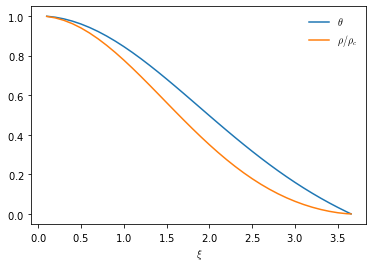

In [3]:
p = Polytrope(1.5)
p.plot()

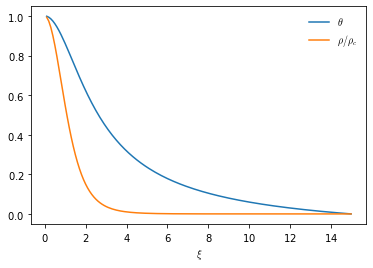

In [4]:
p = Polytrope(4)
p.plot()

### properties with varying polytropic index
Here's a table of the important parameters

In [5]:
for i, nindex in enumerate([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]):
    p = Polytrope(nindex)
    params = p.get_params()
    if i == 0:
        print(f"{'n':4} : {'ξ_1':^20} {'-ξ_1**2 dθ/ξ |_{ξ_1}':^20}")
    print(f"{nindex:4} : {params[0]:20.10g} {params[1]:20.10g}")

n    :         ξ_1          -ξ_1**2 dθ/ξ |_{ξ_1}
   0 :                 2.45          4.902041667
 0.5 :          2.752694496          3.787683423
   1 :          3.141591734          3.141593131
 1.5 :          3.653752765          2.714056597
   2 :          4.352873728          2.411044249
 2.5 :          5.355275716          2.187197386
   3 :          6.896852479          2.018233566
 3.5 :          9.535820161           1.89055466
   4 :           14.9716009          1.797227648
 4.5 :           31.8367713          1.737797137


### accuracy

We can look at the accuracy by varying the step size, $h$, we use in the Runge-Kutta integration.

In [6]:
for i, h in enumerate([1, 0.5, 0.25, 0.125]):
    p = Polytrope(1.5, h0=h, first_order=False)
    params = p.get_params()
    if i == 0:
        print(f"{'h0':6} : {'ξ_1':^20} {'-ξ_1**2 dθ/ξ |_{ξ_1}':^20}")
    print(f"{h:6} : {params[0]:20.10g} {params[1]:20.10g}")

h0     :         ξ_1          -ξ_1**2 dθ/ξ |_{ξ_1}
     1 :          3.633871294          2.743950221
   0.5 :           3.65249039          2.714155735
  0.25 :          3.653696012          2.714041475
 0.125 :          3.653751185          2.714057167


we see that, for this value of n, once we have a stepsize $h = 0.25$, our solution changes only in the 3rd decimal place.  So we are pretty accurate then.

## Alternate approach: SciPy

Instead of writing our own integrator, we can use those built into SciPy.  We do need to be careful to ensure that we stop when $\theta$ reaches 0.  The SciPy `solve_ivp()` integrator uses Runge-Kutta by default.  Additionally, it has "events" that can be used to stop the integration when we reach the surface of the star.

In [7]:
from scipy import integrate

We define the righthand side function now.  It is almost the same as I did above, except that since the built in solver we go past the surface of the star as it seaches for the actual surface, we need to protect against taking a negative number to a fractional power.  I do this here by adding an `abs()` in the `zdot` term.

In [8]:
def le_rhs(xi, yvec, n):
    y, z = yvec
    ydot = z
    if xi == 0.0:
        zdot = (2.0/3.0) - y**n
    else:
        zdot = -2.0*z/xi - abs(y)**n
    return [ydot, zdot]
        

Next we define an event that the integrator will use to determine when to stop.  Our function surface just returns our variable $y = \theta$.  We add 2 attributes to it (this is a little bit of a clumsy way of doing things).  The first says that when the event is met, the integration should stop.  The second says that the condition we are looking for is a change in the sign of the return value.

In [9]:
def surface(xi, y, n):
    return y[0]
surface.terminal = True
surface.direction = -1

Now we setup the integration.  By default it will do Runge-Kutta, but it will vary the step size as needed to get a reasonable solution.  We specify `dense_output=True` so we can look at the entire solution.  We also need to pass an extra argument to our `le_rhs()` routine -- the polytropic index `n`, which we do using the `args` keyword argument.

In [10]:
n = 1.5

# initial conditions
y0 = [1, 0]

# maximum possible xi value -- we'll likely stop before this
ximax = 100

sol = integrate.solve_ivp(le_rhs, [0, ximax], y0,
                          dense_output=True, events=surface, args=(n,))

Now that it is integrated, we can see the points where it actually needed the solution as `sol.t`.  $\xi_1$ would be the last of these points.

In [11]:
xi1 = sol.t[-1]
print(xi1)

3.65782463879207


Now we fill in the solution to get the dense output.

In [12]:
xi = np.linspace(0, xi1, 100)
y = sol.sol(xi)

We can then plot this polytrope

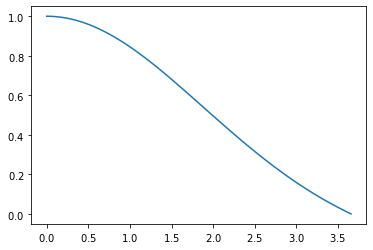

In [13]:
plt.plot(xi, y[0,:])